In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm

from DynamicalSystemLayer import *
from VaeNeuralODELayer import *

# Data generation

In [39]:
p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()

In [40]:
obs.shape

torch.Size([200, 1, 2])

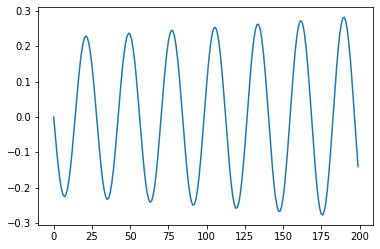

In [41]:
plt.plot(obs[:,:,0].numpy())
plt.show()

In [56]:
obs = obs.squeeze(1)
pend_data = obs[:,0]
window_len = 5
window_set = torch.zeros(5,40)
for k in range(40):
    window_set[:,k] = pend_data[k:(k+5)]

In [46]:
times.shape[0] - 5

195

In [57]:
window_set.shape

torch.Size([5, 40])

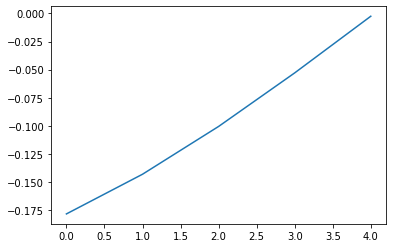

In [63]:
plt.plot(window_set[:,10].numpy())
plt.show()

In [77]:
class LinearODEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x0, t, A):
        time_len = time.size(0)
        x_dim = x.size(1) #x_dim = 1
        z = torch.zeros(time_len, 2)
        z0 = x0
        
        def LinearFun(x,t):
            return A.matmul(x)
        
        with torch.no_grad():
            for it in range(time_len-1):
                z0 = ode_solve(z0, t[it], t[it+1], LinearFun)
                z[it+1] = z0
        ctx.save_for_backward(z.clone(), t, A)        
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        z, t, A = ctx.saved_tensors
        time_len = t.size(0)
        z_dim = z.size(1)
        n_param = np.prod(A)
        
        adzdA = torch.zeros(time_len, z_dim, n_param)
        
        u = adzdA[0]
        
        for it in range(time_len - 1):
            zi = z[it]
            ti = t[it]
            ai = grad_out[it]
            
            adfdz = grad_out.matmul(A)
            adfdA = grad_out.matmul(zi)
            
            def dual_dynamic(u, t):
                return adfdz.matmul(u) + adfdA
            
            u = ode_solve(u, ti, t[it+1], dual_dynamic)
            
            adzdA[it+1] = u
        return adzdA, None, None, None
         

In [ ]:
class LinearODELayer(nn.Module):
    def __init__(self, data_dim):
        super(LinearODELayer, self).__init__()
        self.data_dim = data_dim
        
        self.A = torch.randn(2,2, requires_grad=True)
        
    def forward(self, x):
        z0 = torch.Tensor([x[0], x[1]])
        z = LinearODEFunction.apply()

In [64]:
A = p.reshape(2,2)

In [65]:
A

tensor([[ 0.0000,  1.0000],
        [-0.0500,  0.0000]])

In [67]:
np.prod(A.shape)

4

In [71]:
a = torch.randn(2)
z = torch.randn(2)

In [74]:
(a.matmul(A))

tensor([-2.0727e-04,  1.9471e+00])

In [73]:
a.matmul(z)

tensor(-1.3193)

In [75]:
z

tensor([-0.6792,  0.7535])